# 자전거 대여소 EDA

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'AppleGothic'

In [2]:
rental = pd.read_csv('data/서울특별시 공공자전거 대여소 정보.csv')
rental.head()

,구명,대여소ID,대여소번호,대여소명,대여소 주소,거치대수,위도,경도
0,강남구,ST-777,2301,현대고등학교 건너편,서울특별시 강남구 압구정로 134현대고등학교 건너편,10,37.524071,127.021790
1,강남구,ST-787,2302,교보타워 버스정류장(신논현역 3번출구 후면),서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장,10,37.505581,127.024277
2,강남구,ST-788,2303,논현역 7번출구,서울특별시 강남구 학동로 지하 102논현역 7번출구,15,37.511517,127.021477
3,강남구,ST-789,2304,신영 ROYAL PALACE 앞,서울특별시 강남구 언주로 626신영 ROYAL PALACE앞,10,37.512527,127.035835
4,강남구,ST-790,2305,MCM 본사 직영점 앞,서울특별시 강남구 언주로 734MCM 본사 직영점 앞,10,37.520641,127.034508


In [3]:
rental.shape

(1460, 8)

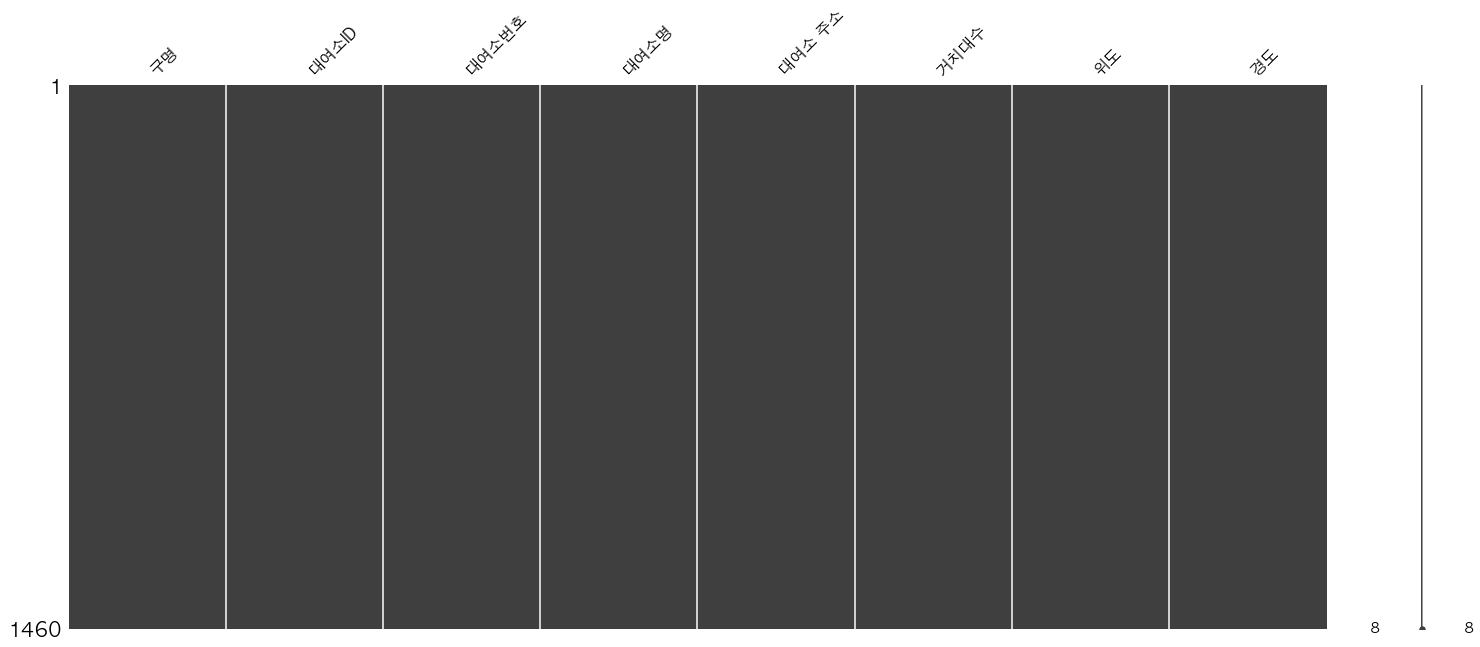

In [4]:
import missingno as msno

msno.matrix(rental)

In [5]:
import folium

bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8)
for i, row in rental.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        fill=True,
    ).add_to(bike_map)
bike_map

히트맵으로 봐볼까?

In [6]:
from folium import plugins

bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8)
plugins.HeatMap(rental[['위도', '경도']].values.tolist(),
                        radius=20,
                        ).add_to(bike_map)
plugins.Fullscreen(positions='topright').add_to(bike_map)
bike_map

In [7]:
import json

geo_path = 'data/seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

### 지역별 대여소 개수 비교

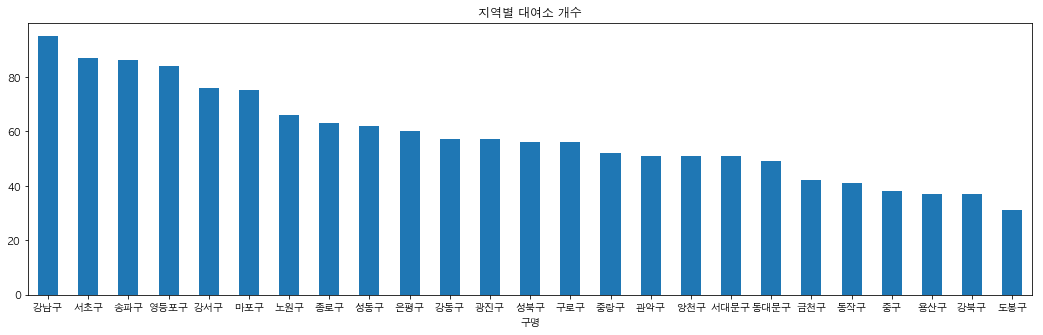

In [8]:
have_bikes = rental.groupby('구명').size()

have_bikes.sort_values(ascending=False, inplace=True)
have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="지역별 대여소 개수")
plt.show()

In [9]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8)
folium.Choropleth(geo_data=geo_str,
                  data=have_bikes,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(bike_map)
bike_map

### 지역별 대여소당 평균 거치대수 비교

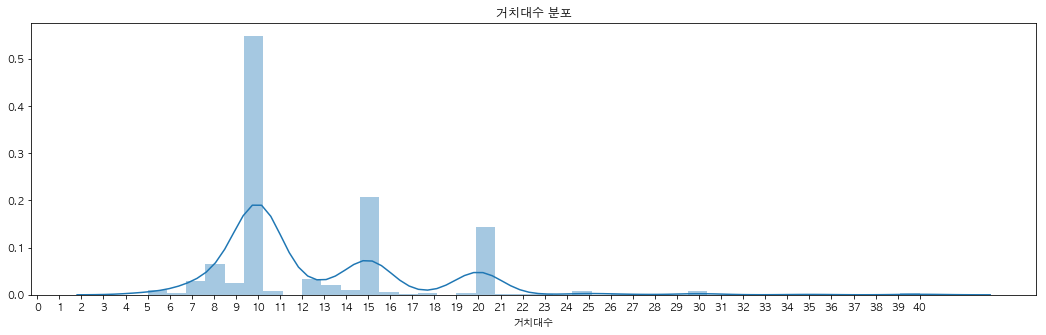

In [10]:
plt.figure(figsize=(18, 5))
sns.distplot(rental['거치대수'])
plt.title("거치대수 분포")
plt.xticks(range(0, 41))
plt.show()

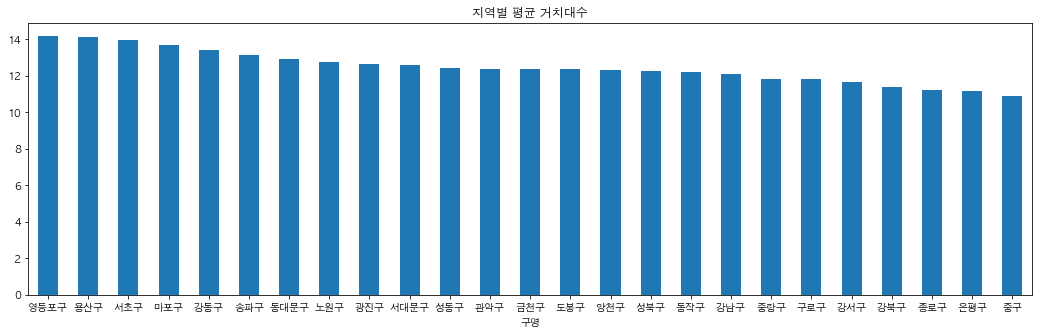

In [11]:
bike_rental = rental.groupby('구명')['거치대수'].sum()
bike_rental = bike_rental / have_bikes
bike_rental.sort_values(ascending=False, inplace=True)
bike_rental.plot(kind='bar', figsize=(18, 5), rot=0, title="지역별 평균 거치대수")
plt.show()

In [12]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8)
folium.Choropleth(geo_data=geo_str,
                  data=bike_rental,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(bike_map)
bike_map

### 지역별, 가장 가까운 대여소간 거리

In [13]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    m = 1000 * km
    return m

In [14]:
dict_dists = {}
for name, df in rental.groupby('구명'):
    dists = []
    for i, i_row in df.iterrows():
        min_dist = float('INF')
        
        for j, j_row in df.iterrows():
            if i == j:
                continue
            distance = haversine(i_row['경도'], i_row['위도'], j_row['경도'], j_row['위도'])       
            min_dist = distance if distance < min_dist else min_dist
                
        dists.append(min_dist)
    dict_dists[name] = dists

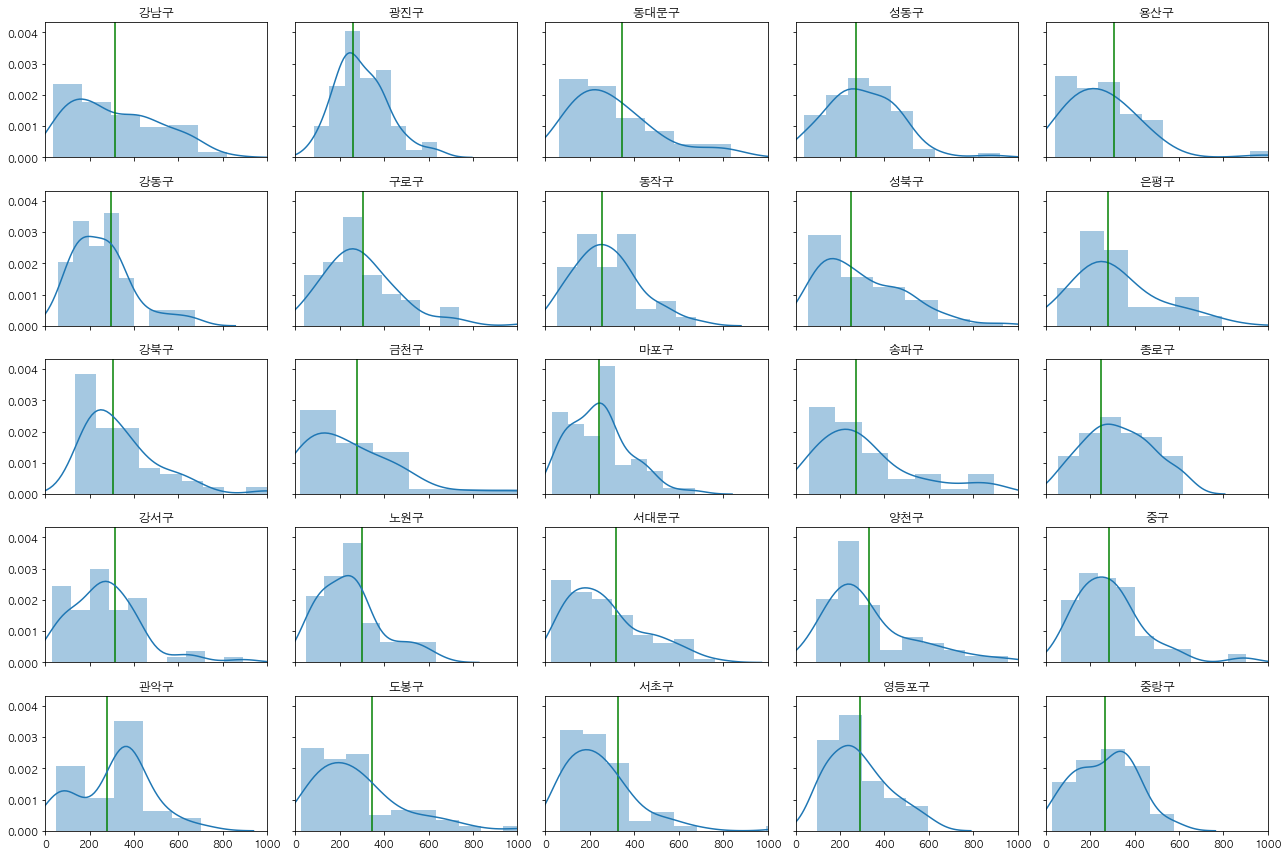

In [15]:
fig, axes = plt.subplots(5, 5, figsize=(18, 12), sharex=True, sharey=True)

i, j = 0, 0
for name, dists in dict_dists.items():
    sns.distplot(dists, ax=axes[i][j])
    axes[j][i].set_title(name)
    axes[j][i].axvline(np.array(dists).mean(), color='green')
    j += 1
    if j >= 5:
        i += 1
        j = 0
    
plt.xlim(0, 1000)
fig.tight_layout()
plt.show()

관악구 분포 보면, 봉우리가 2갠데, 이거 지도에서 직접 확인해보자.

In [16]:
rental.head()

,구명,대여소ID,대여소번호,대여소명,대여소 주소,거치대수,위도,경도
0,강남구,ST-777,2301,현대고등학교 건너편,서울특별시 강남구 압구정로 134현대고등학교 건너편,10,37.524071,127.021790
1,강남구,ST-787,2302,교보타워 버스정류장(신논현역 3번출구 후면),서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장,10,37.505581,127.024277
2,강남구,ST-788,2303,논현역 7번출구,서울특별시 강남구 학동로 지하 102논현역 7번출구,15,37.511517,127.021477
3,강남구,ST-789,2304,신영 ROYAL PALACE 앞,서울특별시 강남구 언주로 626신영 ROYAL PALACE앞,10,37.512527,127.035835
4,강남구,ST-790,2305,MCM 본사 직영점 앞,서울특별시 강남구 언주로 734MCM 본사 직영점 앞,10,37.520641,127.034508


In [17]:
Gwanak = rental[rental['구명'] == '관악구']

bike_map = folium.Map(location=[Gwanak['위도'].mean(), Gwanak['경도'].mean()], zoom_start=14)
for i, row in Gwanak.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        fill=True,
    ).add_to(bike_map)
bike_map

plugins.HeatMap(Gwanak[['위도', '경도']].values.tolist()).add_to(bike_map)
bike_map

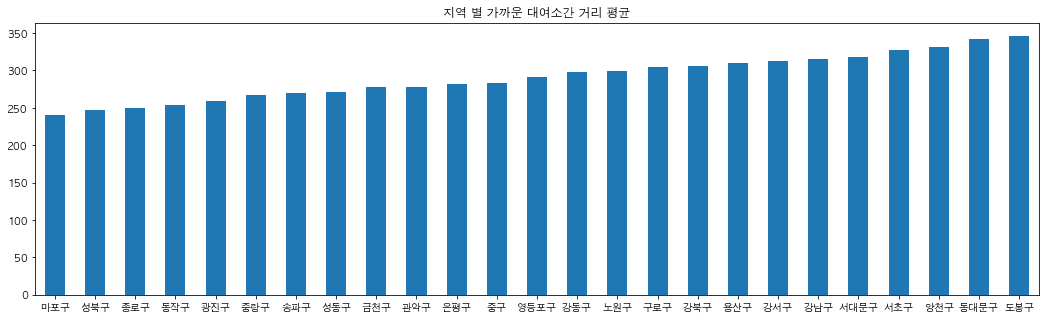

In [18]:
dist_means = {name: np.mean(dists) for name, dists in dict_dists.items() }
dist_means = pd.Series(dist_means)
dist_means.sort_values(inplace=True)
dist_means.plot(kind='bar', figsize=(18, 5), rot=0, legend=False, title="지역 별 가까운 대여소간 거리 평균")
plt.show()

In [19]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8)
folium.Choropleth(geo_data=geo_str,
                  data=dist_means,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(bike_map)
bike_map